In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_train_data(filename):
    train = pd.read_csv(filename,encoding='big5')
    
    ### seperate data 
    data = [[] for i in range(18)]
    for r,d in enumerate(train.iloc[:,3:].values):
        data[r%18].append(d)
    data = np.array(data).reshape((18,-1))
    
    return data

def load_test_data(filename):
    test = pd.read_csv(filename,encoding='big5',header = None)
    test_data = [[] for i in range(18)]
    for r,d in enumerate(test.iloc[:,2:].values):
        test_data[r%18].append(d)
    test_data = np.array(test_data).reshape((18,-1))
    
    return test_data

In [2]:
train_data = load_train_data('./data/train.csv')
test_data = load_test_data('./data/test.csv')

print(train_data.shape)
print(test_data.shape)

(18, 5760)
(18, 2160)


In [3]:
def get_train_data(data,hours):
    train_x_18 = []
    train_x_1 = []
    train_y = []

    for i in range(0,data.shape[1]-hours):
        train_x_18.append(data[:,i:i+hours].reshape((-1)))
        train_x_1.append(data[9,i:i+hours].reshape((-1)))
        train_y.append(data[9][i+hours])
        
    train_x_18 = np.array(train_x_18)
    train_x_1 = np.array(train_x_1)
    train_y = np.array(train_y).astype(np.float64)

    # replace NR to 0
    train_x_18[train_x_18 == 'NR'] = 0
    train_x_18 = train_x_18.astype(np.float64)
    train_x_1 = train_x_1.astype(np.float64)
    
    return train_x_18, train_x_1, train_y

def get_test_data(data,hours):
    test_x_18 = []
    test_x_1 = []
    
    for i in range(0,data.shape[1],hours):
        test_x_18.append(data[:,i:i+hours].reshape(-1))
        test_x_1.append(data[9,i:i+hours].reshape(-1))
        
    test_x_18 = np.array(test_x_18)
    test_x_1 = np.array(test_x_1)
    
    test_x_18[test_x_18 == 'NR'] = 0
    test_x_18 = test_x_18.astype(np.float64)
    test_x_1 = test_x_1.astype(np.float64)
    return test_x_18, test_x_1

In [4]:
train_x_18_9, train_x_1_9, train_y_9 = get_train_data(train_data,9)
print(train_x_18_9.shape)
print(train_x_1_9.shape)
print(train_y_9.shape)

train_x_18_5, train_x_1_5, train_y_5 = get_train_data(train_data,5)
print(train_x_18_5.shape)
print(train_x_1_5.shape)
print(train_y_5.shape)

test_x_18_9, test_x_1_9 = get_test_data(test_data,9)
print(test_x_18_9.shape)
print(test_x_1_9.shape)

test_x_18_5, test_x_1_5 = get_test_data(test_data,5)
print(test_x_18_5.shape)
print(test_x_1_5.shape)

(5751, 162)
(5751, 9)
(5751,)
(5755, 90)
(5755, 5)
(5755,)
(240, 162)
(240, 9)
(432, 90)
(432, 5)


In [5]:
def feature_scaling(train_x,test_x):
    data = np.vstack([train_x,test_x])
    feature_mean = np.mean(data,axis = 0) 
    feature_var = np.var(data,axis = 0)
    data = (data - feature_mean)/feature_var 
    
    return data[:-240,:],data[-240:,:]

In [229]:
train_x,test_x = feature_scaling(train_x,test_x)
print(train_x.shape)
print(train_y.shape)

(5751, 162)
(5751,)


In [6]:
# add bias term
train_x_18_9 = np.hstack([train_x_18_9,np.ones((train_x_18_9.shape[0],1))])
train_x_1_9 = np.hstack([train_x_1_9,np.ones((train_x_1_9.shape[0],1))])
test_x_18_9 = np.hstack([test_x_18_9,np.ones((test_x_18_9.shape[0],1))])
test_x_1_9 = np.hstack([test_x_1_9,np.ones((test_x_1_9.shape[0],1))])

train_x_18_5 = np.hstack([train_x_18_5,np.ones((train_x_18_5.shape[0],1))])
train_x_1_5 = np.hstack([train_x_1_5,np.ones((train_x_1_5.shape[0],1))])
test_x_18_5 = np.hstack([test_x_18_5,np.ones((test_x_18_5.shape[0],1))])
test_x_1_5 = np.hstack([test_x_1_5,np.ones((test_x_1_5.shape[0],1))])

In [7]:
def GD(train_x,train_y,lr,iterations,lamda = 0):
    w = np.zeros((train_x.shape[1]))
    cost = []

    for i in range(iterations):
        pre = train_x.dot(w)
        loss = pre - train_y
        gradient = 2*np.dot(train_x.T,loss)/train_x.shape[0] + lamda*w
        w -= lr*gradient
        cost.append((np.sum(loss**2)/train_x.shape[0]))
    return w,cost

In [15]:
def Adagrad(train_x,train_y,lr,iterations,lamda = 0):
    w = np.zeros((train_x.shape[1]))
    cost = []
    prev_gra = 0

    for i in range(iterations):
        pre = train_x.dot(w)
        loss = pre - train_y
        gradient = 2*np.dot(train_x.T,loss)/train_x.shape[0] + lamda*w
        prev_gra += gradient**2
        ada = np.sqrt(prev_gra)
        w -= lr*gradient/ada
        cost.append((np.sum(loss**2)/train_x.shape[0]))
    return w,cost

In [9]:
def RMSprop(train_x,train_y,lr,iterations,lamda = 0):
    w = np.zeros((train_x.shape[1]))
    cost = []
    prev_gra = 0

    for i in range(iterations):
        pre = train_x.dot(w)
        loss = pre - train_y
        gradient = 2*np.dot(train_x.T,loss)/train_x.shape[0] + lamda*w
        prev_gra += gradient**2
        ada = np.sqrt(prev_gra)
        w -= lr*gradient/ada
        cost.append((np.sum(loss**2)/train_x.shape[0]))
    return w,cost

In [10]:
def Adam(train_x,train_y,lr,iterations,lamda = 0):
    w = np.zeros((train_x.shape[1]))
    cost = []
    prev_gra = 0

    for i in range(iterations):
        pre = train_x.dot(w)
        loss = pre - train_y
        gradient = 2*np.dot(train_x.T,loss)/train_x.shape[0] + lamda*w
        prev_gra += gradient**2
        ada = np.sqrt(prev_gra)
        w -= lr*gradient/ada
        cost.append((np.sum(loss**2)/train_x.shape[0]))
    return w,cost

In [11]:
w,cost = GD(train_x,train_y,1e-3,50000)
cost[-1]

NameError: name 'train_x' is not defined

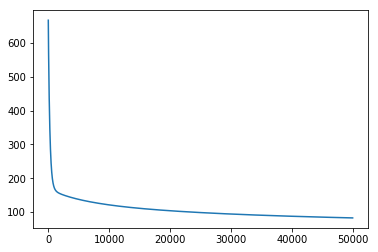

In [248]:
plt.plot([i for i in range(50000-3)],cost[3:])

In [36]:
# 1 feature 5 hour
opt_cost = 100
opt_w = np.ones((train_x_1_5.shape[1]))
for i in [0.02]:
    w,cost = Adagrad(train_x_1_5,train_y_5,i,20000)
    if(cost[-1] < opt_cost):
        opt_cost = cost[-1]
        opt_w = w
    print(cost[-1])

39.71027211417666


In [35]:
# 18 feature 5 hour
opt_cost = 100
opt_w = np.ones((train_x_18_5.shape[1]))
for i in [0.02]:
    w,cost = Adagrad(train_x_18_5,train_y_5,i,20000)
    if(cost[-1] < opt_cost):
        opt_cost = cost[-1]
        opt_w = w
    print(cost[-1])

35.113078979170396


In [27]:
# 1 feature 9 hour
opt_cost = 100
opt_w = np.ones((train_x_1_9.shape[1]))
for i in [0.02]:
    w,cost = Adagrad(train_x_1_9,train_y_9,i,20000)
    if(cost[-1] < opt_cost):
        opt_cost = cost[-1]
        opt_w = w
    print(cost[-1])

38.60665677196431


In [16]:
# 18 feature 9 hour
opt_cost = 100
opt_w = np.ones((train_x_18_9.shape[1]))
for i in [0.02]:
    w,cost = Adagrad(train_x_18_9,train_y_9,i,20000)
    if(cost[-1] < opt_cost):
        opt_cost = cost[-1]
        opt_w = w
    print(cost[-1]**0.5)

5.84459969193


In [17]:
train_x_18_9.shape

(5751, 163)

In [18]:
def rmse(pre,test):
    tmp = 0
    for i,p in enumerate(pre):
        tmp += (p-test[i])**2
    return (tmp/pre.shape[0])**0.5

In [23]:
# split data to train and validation 
length = int(train_x_18_9.shape[0]/3)
split_train_x_18_9 = train_x_18_9[:length*2,:]
split_train_y_9 = train_y_9[:length*2]

split_val_x_18_9 = train_x_18_9[length*2:,:]
split_val_y_9 = train_y_9[length*2:]

lr = [0.02,0.1,0.2,0.3,0.4,0.5,1]
lamda = [0,0.01,0.1,0.5,1,2]

opt_cost = 100
opt_w = np.ones((train_x_18_9.shape[1]))

for l in lr:
    for lam in lamda:
        w,cost = Adagrad(split_train_x_18_9,split_train_y_9,l,20000,lam)
        pre = np.dot(split_val_x_18_9,w)
        cost = rmse(pre,split_val_y_9)
        
        if(cost < opt_cost):
            opt_cost = cost
            opt_w = w
            opt_coef = (l,lam)
        print((l,lam),cost)

(0.02, 0) 5.62427040966
(0.02, 0.01) 5.62438194306
(0.02, 0.1) 5.62500593498
(0.02, 0.5) 5.6254612807
(0.02, 1) 5.62662661802
(0.02, 2) 5.63359032765
(0.1, 0) 5.62308280752
(0.1, 0.01) 5.62324928166
(0.1, 0.1) 5.62436366324
(0.1, 0.5) 5.62641772342
(0.1, 1) 5.62859507574
(0.1, 2) 5.63623438941
(0.2, 0) 5.62452620675
(0.2, 0.01) 5.62469746336
(0.2, 0.1) 5.62586047914
(0.2, 0.5) 5.62810313678
(0.2, 1) 5.630406238
(0.2, 2) 5.63811592628
(0.3, 0) 5.62509580209
(0.3, 0.01) 5.6252685366
(0.3, 0.1) 5.62644695687
(0.3, 0.5) 5.62875103892
(0.3, 1) 5.63109526264
(0.3, 2) 5.6388267512
(0.4, 0) 5.62539772747
(0.4, 0.01) 5.62557117887
(0.4, 0.1) 5.62675714536
(0.4, 0.5) 5.62909164199
(0.4, 1) 5.63145625287
(0.4, 2) 5.63919829655
(0.5, 0) 5.62558443657
(0.5, 0.01) 5.62575831102
(0.5, 0.1) 5.62694875475
(0.5, 0.5) 5.62930140153
(0.5, 1) 5.63167818584
(0.5, 2) 5.6394264479
(1, 0) 5.62597048176
(1, 0.01) 5.62614518632
(1, 0.1) 5.62734446998
(1, 0.5) 5.62973318938
(1, 1) 5.63213418272
(1, 2) 5.639894616

In [25]:
opt_coef

(0.1, 0)

In [19]:
opt_w

array([-5.46227603e-03, -1.38475160e-02, -2.69443961e-03, -1.72178991e-02,
       -1.37267864e-03,  1.26807630e-03,  3.49498739e-03, -3.82558612e-03,
        2.45317602e-02,  2.22352553e-02,  3.05717890e-02,  3.89331859e-02,
        2.92968741e-02,  4.59270116e-02,  7.11612298e-02,  6.44754913e-02,
        7.56308685e-02,  1.29809349e-01,  4.78095689e-03, -2.29097397e-02,
        5.51486985e-02, -9.68806233e-02,  1.93669012e-01, -7.50386999e-02,
       -1.57227624e-01,  2.79772280e-01,  7.72973264e-01, -1.51172932e-01,
       -3.14471859e-02, -5.06214364e-03,  7.00874400e-02,  1.73947880e-01,
       -3.70711697e-02, -5.27167268e-02,  1.51031468e-02,  3.08366728e-01,
        3.33776252e-02,  3.02304357e-04,  1.09991200e-01, -2.50667028e-02,
       -4.60466911e-03, -6.41362713e-02,  7.12192054e-02,  7.81103034e-02,
       -1.33377173e-01,  7.95896436e-03, -2.23917625e-02, -2.71589196e-02,
       -2.87100474e-02,  2.64741878e-04, -1.39653775e-03, -6.29413514e-02,
       -4.74672427e-02,  

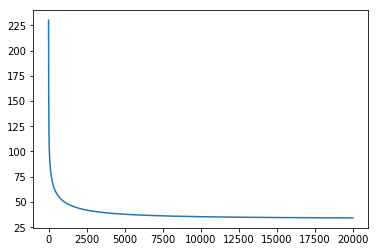

In [294]:
plt.plot([i for i in range(20000-3)],cost[3:])

In [295]:
predict_value = np.dot(test_x,w)

In [296]:
def output_result(filename,predict_value):
    id_ = []
    for i in range(predict_value.shape[0]):
        temp = 'id_'+str(i)
        id_.append(temp)
    output = pd.DataFrame(columns=['id','value'])
    output['id'] = id_
    output['value'] = predict_value
    output.to_csv(filename,index = False)
    
    print(output.head())

In [297]:
output_result('output.csv',predict_value)

     id      value
0  id_0   5.246913
1  id_1  17.055572
2  id_2  24.077396
3  id_3   7.815355
4  id_4  26.901141
